In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime,time
import utils as u
import signals
from tqdm import tqdm

### Optimal min peak restriction

The best restriction is no restriction (??)

In [6]:
changes = np.linspace(0.95,1.00,8)
pnl = []
for change in tqdm(changes):
    signal = signals.signal_analysis(min_peak_change=change)
    pnl.append(signal['return'].sum()) # t takes datetime.time
#     signals.graph_profit(signal)
pnl

100%|██████████| 8/8 [00:51<00:00,  6.50s/it]


[5.470000000000001,
 7.3100000000000005,
 5.1899999999999995,
 3.6400000000000006,
 4.5600000000000005,
 5.010000000000001,
 5.010000000000001,
 5.44]

### Signal data 

In [10]:
signal = signals.signal_analysis()
signal.tail(10)

,event_id,minutes,line,chl_hi,chl_low,odd_change,peak,peak_change,signal,result_corner,correct_prediction,return
19,20200219WED16,2020-02-19 01:33:45,4.5,2.43,1.49,1.284483,1,0.9675,1,5.0,0,-1.00
20,20200219WED3,2020-02-19 01:32:28,8.5,2.50,1.46,1.280702,1,0.9733,1,7.0,1,0.46
21,20200220THU1,2020-02-20 01:32:49,9.5,2.50,1.46,1.269565,1,0.9542,1,9.0,1,0.46
22,20200220THU20,2020-02-20 01:34:58,14.5,2.48,1.47,1.278261,1,0.9545,1,13.0,1,0.47
23,20200220THU22,2020-02-20 01:33:18,18.5,2.55,1.45,1.178862,1,1.0902,-1,20.0,1,1.55
24,20200220THU9,2020-02-20 01:31:55,7.5,2.45,1.48,1.275862,1,1.0803,-1,9.0,1,1.45
25,20200221FRI1,2020-02-21 01:35:46,9.5,2.45,1.48,1.264957,1,0.6435,1,9.0,1,0.48
26,20200221FRI3,2020-02-21 01:37:29,14.5,2.55,1.45,1.271930,1,0.9797,1,12.0,1,0.45
27,20200221FRI35,2020-02-21 01:33:07,9.5,2.45,1.48,1.275862,1,0.9610,1,11.0,0,-1.00
28,20200222SAT1,2020-02-22 01:36:37,10.5,2.45,1.48,1.243697,1,0.9673,1,12.0,0,-1.00


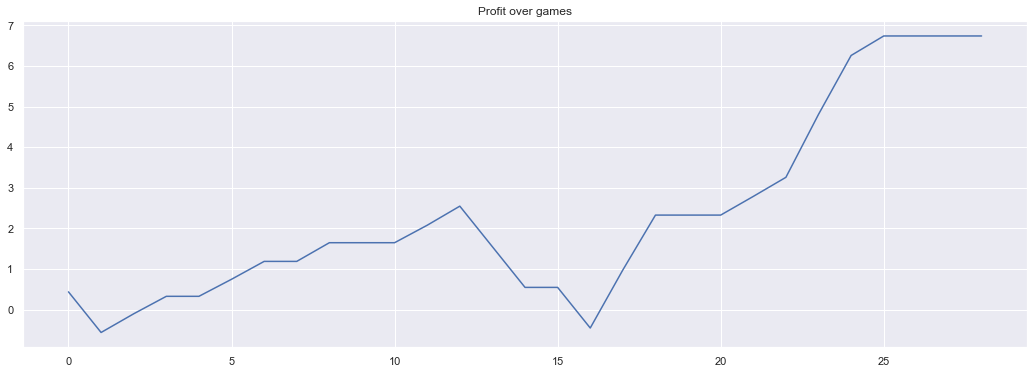

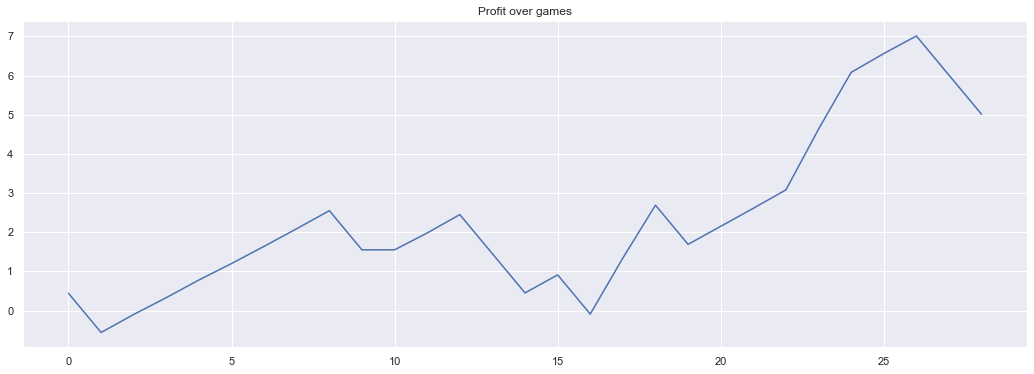

In [9]:
signal = signals.signal_analysis(min_peak_change=0.96)
signals.graph_profit(signal)

signal = signals.signal_analysis(min_peak_change=0.98)
signals.graph_profit(signal)

### Plot one game

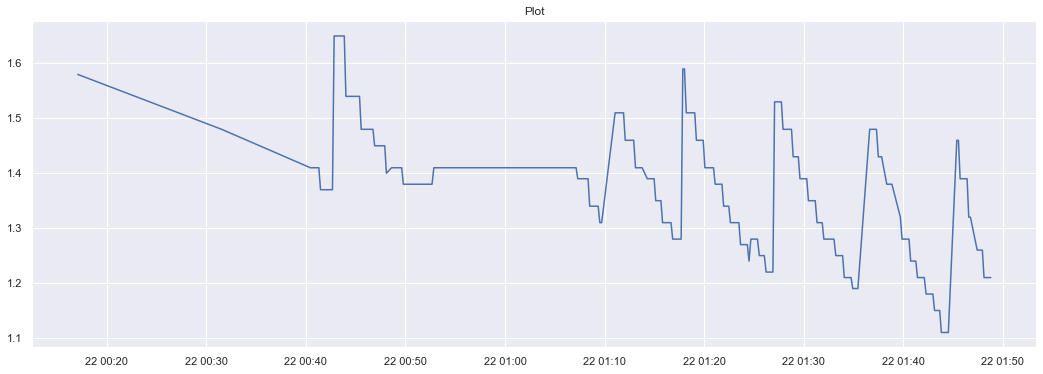

In [14]:
data = u.signal_data_pipeline('20200222SAT1')
u.graph(data.minutes,data.chl_low,'Plot')

### Baseline model
Random bet on lowest chl_low at a specified t

In [18]:
def baseline_model(t):
    signal_list = None
    for event_id in [file[:-4] for file in os.listdir('data/') if '2020' in file]:
        # data pipeline
        data = u.signal_data_pipeline(event_id)
        data = data[data.minutes >= datetime.combine(datetime.strptime(event_id[:8],"%Y%m%d"), t)]
        peaks = data
        if signal_list is None:
            if peaks.empty == False:
                signal_list = peaks.iloc[[0]]
        else:
            if peaks.empty == False:
                signal_list = pd.concat([signal_list, peaks.iloc[[0]]], ignore_index=True)

    # merge current results
    result = pd.read_csv('/Users/TysonWu/dev/odds-crawl-app/odds-crawl-app/development/result_collection/match_corner_result.csv')
    signals = signal_list.merge(result[['event_id', 'result_corner']], how='inner', on='event_id')

    # exclude games without results
    signals = signals[~signals.result_corner.isna()]

    # calculate return
    signals['correct_prediction'] = np.where(signals.line > signals.result_corner, 1, 0)
    signals['return'] = np.where(signals.correct_prediction == 1, signals.chl_low-1, -1)
    signals = signals.sort_values(by='event_id').reset_index(drop=True)
    return signals['return'].sum()

100%|██████████| 36/36 [03:41<00:00,  6.16s/it]


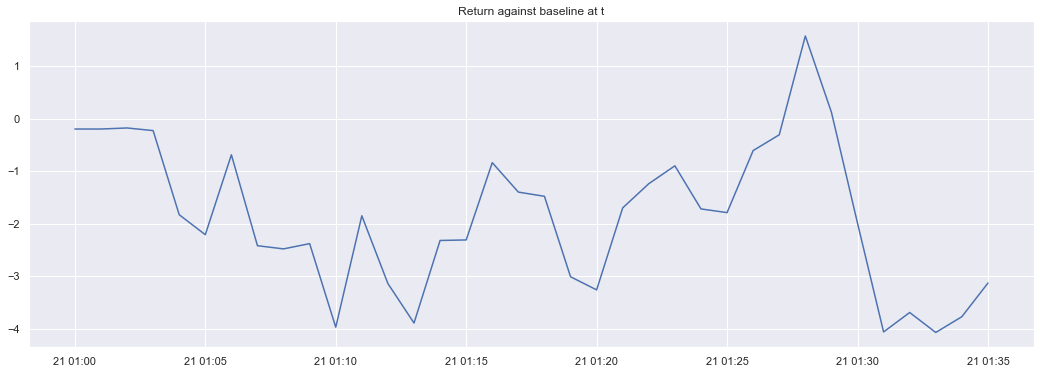

In [20]:
from tqdm import tqdm
from datetime import date

# timelist = [time(0,i,0) for i in range(60)] + [time(1,i,0) for i in range(36)]
timelist = [time(1,i,0) for i in range(36)]
pnl = []
for times in tqdm(timelist):
    profit = baseline_model(t=times)
    pnl.append(profit) # t takes datetime.time

u.graph([datetime.combine(date.today(), time)for time in timelist], pnl, 'Return against baseline at t')